#### Imports and env creation

In [1]:
# from __future__ import annotations

from minigrid.core.constants import COLOR_NAMES
from minigrid.core.grid import Grid
from minigrid.core.mission import MissionSpace
from minigrid.core.world_object import Door, Goal, Key, Wall
from minigrid.manual_control import ManualControl
from minigrid.minigrid_env import MiniGridEnv
from minigrid.core.constants import IDX_TO_OBJECT, OBJECT_TO_IDX

from minigrid.core.actions import Actions
from dataclasses import dataclass, field 
from typing import Set
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

pygame 2.5.2 (SDL 2.28.2, Python 3.10.18)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
class SimpleEnv(MiniGridEnv):
    def __init__(
        self,
        size=5,
        agent_start_pos=(1, 1),
        agent_start_dir=0,
        max_steps: int | None = None,
        **kwargs,
    ):
        self.agent_start_pos = agent_start_pos
        self.agent_start_dir = agent_start_dir

        mission_space = MissionSpace(mission_func=self._gen_mission)

        super().__init__(
            mission_space=mission_space,
            grid_size=size,
            max_steps=256,
            **kwargs,
        )

    @staticmethod
    def _gen_mission():
        return "grand mission"
    # MiniGridEnv._gen_grid
    
    def _gen_grid(self, width, height):
      self.grid = Grid(width, height)
      self.grid.wall_rect(0, 0, width, height)

      if self.agent_start_pos is not None:
          self.agent_pos = self.agent_start_pos
          self.agent_dir = self.agent_start_dir
      else:
          self.place_agent()
      self.valid_actions = {Actions.left, Actions.right, Actions.forward}
    
      
      self.put_obj(Goal(), width - 2, height - 2)

    #   for i in range(0, height):
    #     self.grid.set(5, i, Wall())

    #   self.grid.set(5, 6, Door(COLOR_NAMES[0], is_locked=True))
    #   self.grid.set(3, 6, Key(COLOR_NAMES[0]))
    
    def get_array_repr(self, with_agent=True):
        grid_array = self.unwrapped.grid.encode()[:,:,0]
        # print(grid_array)
        # print(self.agent_pos)
        grid_array[self.agent_pos[0],self.agent_pos[1]]=OBJECT_TO_IDX['agent']
        return grid_array.T
    

# env = SimpleEnv(render_mode="human")
# manual_control = ManualControl(env, seed=42)

env = SimpleEnv()
env.reset()
print(env.get_array_repr())

# enable manual control for testing
# manual_control.start()

map_numbers = [1,2,8,10]

[[ 2  2  2  2  2]
 [ 2 10  1  1  2]
 [ 2  1  1  1  2]
 [ 2  1  1  8  2]
 [ 2  2  2  2  2]]


#### Agent motion

In [3]:
from agents.random import RandomAgent
n_steps = 10000

random_action_agent = RandomAgent(valid_actions=env.valid_actions)

dirarr = ['Right', 'Down', 'Left','Up']
actions_to_idx = {Actions.left:0, Actions.right:1, Actions.forward:2}

image_list = []

for i in range(n_steps):
    action = random_action_agent.act()
    arr = env.get_array_repr().flatten()
    arr = np.append(arr, [actions_to_idx[action], env.agent_dir])
    image_list.append(arr)
    # print(dirarr[env.agent_dir])
    # print(action)
    env.step(action)
    # print(env.get_array_repr())

# print(image_list)

#### Helper functions

In [4]:
import torch
from torch import nn, optim

In [7]:
print(torch.__version__)
print(torch.cuda.is_available())  # This should return True if CUDA is available
print(torch.cuda.current_device())  # Shows the current GPU device id (e.g., 0)
print(torch.cuda.get_device_name(0))  # Displays the GPU name
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

2.1.1+cu121
True
0
NVIDIA GeForce MX330
Using device: cuda


In [26]:
#(Modified) Neuromatch helper funcitons
def init_weights_kaiming_normal(layer):
  """
  Initializes weights from linear PyTorch layer
  with kaiming normal distribution.

  Args:
    layer (torch.Module)
        Pytorch layer

  Returns:
    Nothing.
  """
  # check for linear PyTorch layer
  if isinstance(layer, nn.Linear):
    # initialize weights with kaiming normal distribution
    nn.init.kaiming_normal_(layer.weight.data)
    

def runSGD(net, input_train, target_train, input_test, target_test, criterion='cel',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        print final loss

  Returns:
    Nothing.
  """

  # 1. Define the device
  # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  device = torch.device('cpu')
  print(f"Using device: {device}")

  # 2. Move the network to the device
  net.to(device)

  # 3. Move the main tensors to the device (crucial for initial setup)
  input_train = input_train.to(device)
  target_train = target_train.to(device)
  input_test = input_test.to(device)
  target_test = target_test.to(device)

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  elif criterion == 'cel':
    loss_fn = nn.CrossEntropyLoss() 
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Move the loss function to the device if it has parameters (CrossEntropyLoss does not, 
  # but it's good practice for others like L1Loss which might have reduction='none')
  loss_fn.to(device)

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    
    shuffle_idx = np.random.permutation(len(input_train))

    batches_input = torch.split(input_train[shuffle_idx], batch_size)
    batches_target = torch.split(target_train[shuffle_idx], batch_size)

    batches = zip(batches_input, batches_target)


    shuffle_idx = np.random.permutation(len(input_train))
    # batches = torch.split(input_train[shuffle_idx], batch_size)
    # for batch in batches:
    #   output_train = net(batch)
    #   loss = loss_fn(output_train, batch)
    for batch_input, batch_target in batches:
      batch_input = batch_input.float()
      output_train = net(batch_input)  # Forward pass on the input batch
      loss = loss_fn(output_train, batch_target)  # Compare output with the target
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i+1}/{n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, target_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, target_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, target_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, target_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, target_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, target_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()


#### Input preparation

In [ ]:
X_train, X_test = train_test_split(image_list, test_size=0.2, random_state=42)

target_train = X_train[1:]
input_train = X_train[:-1]
target_test = X_test[1:]
input_test = X_test[:-1]

target_train = torch.tensor(target_train, dtype=torch.int64)
input_train = torch.tensor(input_train, dtype=torch.int64)
target_test = torch.tensor(target_test, dtype=torch.int64)
input_test = torch.tensor(input_test, dtype=torch.int64)


def one_hot_encode_set(values, classes):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    one_hot = torch.zeros(len(classes))
    one_hot[classdict[values.item()]] = 1
    return one_hot

def continuous_class(values, classes):
    classdict = {}
    for i in range(len(classes)):
        classdict[classes[i]] = i
    val = classdict[values.item()]
    return torch.tensor([val])


# Define a function for one-hot encoding
def one_hot_encode(values, num_classes):
    one_hot = torch.zeros(num_classes)
    one_hot[values] = 1
    return one_hot

# Function to process the entire array (each input array of shape [length])
def process_input(input_array):
   # First 25 positions: one-hot encoded into 11 classes (25*11 = 275 total)
    # first_part = torch.cat([one_hot_encode(input_array[i], 11) for i in range(25)])
    first_part = torch.cat([one_hot_encode_set(input_array[i], map_numbers) for i in range(25)])
    # first_part = torch.cat([continuous_class(input_array[i], map_numbers) for i in range(25)])

    # 26th position: one-hot encoded into 3 classes
    second_part = one_hot_encode(input_array[25], 3)
    
    # Last position: one-hot encoded into 4 classes
    third_part = one_hot_encode(input_array[26], 4)

    # print(torch.cat([first_part, second_part, third_part], dim=0))
    # Concatenate all parts to form the final one-hot encoded array
    return torch.cat([first_part, second_part, third_part], dim=0)

# Apply to the whole dataset
input_train_processed = torch.stack([process_input(x) for x in input_train])
input_test_processed = torch.stack([process_input(x) for x in input_test])
target_train_processed = torch.stack([process_input(x) for x in target_train])
target_test_processed = torch.stack([process_input(x) for x in target_test])

# print(target_train)
# print(input_train)


#### Autoencoder training

In [14]:
encoding_size=20
input_size=input_train_processed.size(1)
model = nn.Sequential(
    nn.Linear(input_size, int(input_size / 2)),
    nn.ReLU(),
    nn.Linear(int(input_size / 2), int(input_size / 3)),
    nn.ReLU(),
    nn.Linear(int(input_size / 3), encoding_size),
    nn.ReLU(),
    nn.Linear(encoding_size, int(input_size / 3)),
    nn.ReLU(),
    nn.Linear(int(input_size / 3), int(input_size / 2)),
    nn.ReLU(),
    nn.Linear(int(input_size / 2), input_size),
    )

# model[:-2].apply(init_weights_kaiming_normal)

n_l = 4
encoder = model[:n_l]
decoder = model[n_l:]
print(f'Encoder \n\n {encoder}\n')
print(f'Decoder \n\n {decoder}')

Encoder 

 Sequential(
  (0): Linear(in_features=107, out_features=53, bias=True)
  (1): ReLU()
  (2): Linear(in_features=53, out_features=35, bias=True)
  (3): ReLU()
)

Decoder 

 Sequential(
  (4): Linear(in_features=35, out_features=20, bias=True)
  (5): ReLU()
  (6): Linear(in_features=20, out_features=35, bias=True)
  (7): ReLU()
  (8): Linear(in_features=35, out_features=53, bias=True)
  (9): ReLU()
  (10): Linear(in_features=53, out_features=107, bias=True)
)


Using device: cpu
Epoch 	 Loss train 	 Loss test
1/156	 94.5201		 94.6468
2/156	 94.5213		 94.6362
3/156	 94.5193		 94.6468
4/156	 94.5223		 94.6416
5/156	 94.5196		 94.6432
6/156	 94.5182		 94.6425
7/156	 94.5176		 94.6390
8/156	 94.5191		 94.6439
9/156	 94.5221		 94.6455
10/156	 94.5202		 94.6434
11/156	 94.5207		 94.6464
12/156	 94.5211		 94.6422
13/156	 94.5255		 94.6387
14/156	 94.5202		 94.6486
15/156	 94.5188		 94.6407
16/156	 94.5191		 94.6418
17/156	 94.5188		 94.6405
18/156	 94.5189		 94.6446
19/156	 94.5187		 94.6425
20/156	 94.5192		 94.6439
21/156	 94.5179		 94.6408
22/156	 94.5187		 94.6368
23/156	 94.5195		 94.6415
24/156	 94.5203		 94.6438
25/156	 94.5190		 94.6469
26/156	 94.5224		 94.6446
27/156	 94.5169		 94.6445
28/156	 94.5169		 94.6447
29/156	 94.5173		 94.6376
30/156	 94.5177		 94.6467
31/156	 94.5178		 94.6522
32/156	 94.5205		 94.6408
33/156	 94.5182		 94.6389
34/156	 94.5185		 94.6464
35/156	 94.5170		 94.6509
36/156	 94.5205		 94.6394
37/156	 94.5167		 94.647

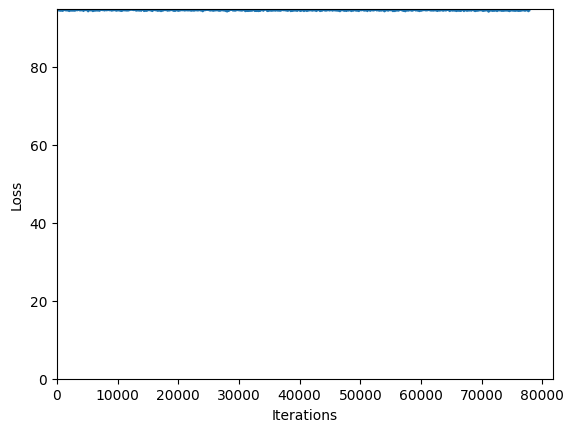

In [27]:
n_epochs = 156
batch_size = 16

runSGD(model, input_train_processed, target_train_processed, input_test_processed, target_test_processed, n_epochs=n_epochs, batch_size=batch_size)

In [20]:
input_test_processed = input_test_processed.to(device)
output = model(input_test_processed)  # Model output (logits or probabilities)
# torch.set_printoptions(profile="full")
# print(output)
output = output.cpu() 
# Initialize a list to hold the decoded outputs for each observation
decoded_outputs = []

for i in range(output.size(0)):  # Loop over each sample in the batch
    # Extract the blocks of the output
    first_25 = output[i, :input_train_processed.size(1)-7].reshape(25, (input_train_processed.size(1)-7)//25)   # First 25 blocks of size 11
    second_block = output[i, input_train_processed.size(1)-7:input_train_processed.size(1)-4]    # Next block of size 3
    third_block = output[i, input_train_processed.size(1)-7:]             # Last block of size 4

    # Decode each block by taking the argmax (index of max value)
    decoded_first_25 = torch.argmax(first_25, dim=1)  # 25 values, each between 0-10
    decoded_second = torch.argmax(second_block)       # Single value between 0-2
    decoded_third = torch.argmax(third_block)         # Single value between 0-3
    
    mapping = torch.tensor(map_numbers)
    decoded_first_25 = mapping[decoded_first_25]
    
    # Combine the decoded values into a single list for this observation
    decoded_sample = torch.cat([decoded_first_25, decoded_second.unsqueeze(0), decoded_third.unsqueeze(0)])
    
    # Append the decoded sample to the final list
    decoded_outputs.append(decoded_sample)

# Convert to tensor if needed
decoded_outputs = torch.stack(decoded_outputs)
print(decoded_outputs)

tensor([[2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 1, 1],
        [2, 2, 2,  ..., 2, 2, 2],
        ...,
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 2, 2],
        [2, 2, 2,  ..., 2, 1, 1]])


In [21]:
for i in range(min(10,decoded_outputs.size(0))):
    # Print the input, decoded grid, and target test grid side by side
    print(f"Sample {i + 1}:")
    
    # Input grid (first 25 values reshaped into 5x5)
    print("Input Grid:")
    print(input_test[i, :25].reshape(5, 5).int())
    
    # Decoded grid (first 25 values reshaped into 5x5)
    print("Decoded Grid:")
    print(decoded_outputs[i, :25].reshape(5, 5).int())
    
    # Target test grid (first 25 values reshaped into 5x5)
    print("Target Grid:")
    print(target_test[i, :25].reshape(5, 5).int())
    
    # Action and Orientation for input, decoded, and target test
    print(f"Decoded Action: {decoded_outputs[i, 25].item()} | Target Action: {target_test[i, 25].item()} | Input Action: {input_test[i, 25].item()}")
    print(f"Decoded Orientation: {decoded_outputs[i, 26].item()} | Target Orientation: {target_test[i, 26].item()} | Input Orientation: {input_test[i, 26].item()}")
    
    print("=" * 50)  # Separator


Sample 1:
Input Grid:
tensor([[ 2,  2,  2,  2,  2],
        [ 2,  1, 10,  1,  2],
        [ 2,  1,  1,  1,  2],
        [ 2,  1,  1,  8,  2],
        [ 2,  2,  2,  2,  2]], dtype=torch.int32)
Decoded Grid:
tensor([[2, 2, 2, 2, 2],
        [2, 1, 1, 1, 2],
        [2, 1, 1, 1, 2],
        [2, 1, 1, 8, 2],
        [2, 2, 2, 2, 2]], dtype=torch.int32)
Target Grid:
tensor([[ 2,  2,  2,  2,  2],
        [ 2,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  2],
        [ 2, 10,  1,  8,  2],
        [ 2,  2,  2,  2,  2]], dtype=torch.int32)
Decoded Action: 2 | Target Action: 1 | Input Action: 2
Decoded Orientation: 2 | Target Orientation: 0 | Input Orientation: 2
Sample 2:
Input Grid:
tensor([[ 2,  2,  2,  2,  2],
        [ 2,  1,  1,  1,  2],
        [ 2,  1,  1,  1,  2],
        [ 2, 10,  1,  8,  2],
        [ 2,  2,  2,  2,  2]], dtype=torch.int32)
Decoded Grid:
tensor([[2, 2, 2, 2, 2],
        [2, 1, 1, 1, 2],
        [2, 1, 1, 1, 2],
        [2, 1, 1, 8, 2],
        [2, 2, 2, 2, 2]], dtype=tor

In [142]:
print(target_test)

tensor([[ 2,  2,  2,  2,  2,  2,  1, 10,  1,  2,  2,  1,  1,  1,  2,  2,  1,  1,
          8,  2,  2,  2,  2,  2,  2,  0,  3],
        [ 2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  1, 10,  1,  2,  2,  1,  1,
          8,  2,  2,  2,  2,  2,  2,  1,  2],
        [ 2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  1,  1,  1,  2,  2,  1,  1,
         10,  2,  2,  2,  2,  2,  2,  0,  2],
        [ 2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  1,  1,  1,  2,  2,  1,  1,
         10,  2,  2,  2,  2,  2,  2,  2,  3],
        [ 2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  1, 10,  1,  2,  2,  1,  1,
          8,  2,  2,  2,  2,  2,  2,  2,  3],
        [ 2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  1,  1,  1,  2,  2, 10,  1,
          8,  2,  2,  2,  2,  2,  2,  0,  0],
        [ 2,  2,  2,  2,  2,  2,  1,  1, 10,  2,  2,  1,  1,  1,  2,  2,  1,  1,
          8,  2,  2,  2,  2,  2,  2,  1,  0],
        [ 2,  2,  2,  2,  2,  2,  1,  1,  1,  2,  2,  1,  1,  1,  2,  2,  1,  1,
         10,  2,  2,  2,  2,  